__Introduction__                                                   
We are going to reproduce the [Credit Scoring Algorithm](https://www.kaggle.com/code/willianleite/credit-scoring-algorithm) by Willian Trindade Leite and Gui Gui.  As an outline, our project is split into 2 parts: 
1. Logistics Regression
2. K-Nearest Neighbor

**Logistics Regression**

In this notebook, we focus on reproducing the results of the Credit Scoring Algorithm  with Logistic Regression. We will use the same model evaluation metrics as in the original research and compare the results.
In this reproduction, we will focus on the comparison of the model with **non-standardized and standardized** data.
The procedure is as follows:
1. Prepare the date for modelling purpose
2. Split the data into train and test sets
3. Fit the models on the train set **non-standardized and standardized** data
4. Calculate evaluation metrics **non-standardized and standardized** data

In [18]:
# Import the libraries for modelling purpose
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
# Read data from .csv file
data=pd.read_csv("/Users/elgun/Desktop/Reproducible-Research_Project/data/Credit.csv")
credit=data.copy()
# Drop the non-numerical columns
credit=credit.drop(columns=["checkingstatus1","history","purpose","savings","employ","sex","housing","tele","foreign","Unnamed: 0"],axis=1)
# Inspect the dataframe
credit.head()

,Default,duration,amount,installment,residence,age,cards,liable
0,0,6,1169,4,4,67,2,1
1,1,48,5951,2,2,22,1,1
2,0,12,2096,2,3,49,1,2
3,0,42,7882,2,4,45,1,2
4,1,24,4870,3,4,53,2,2


**Split the data into train and test sets**

75% of the data was used for training in the original research. In this project,  70% of the data was used for training.

In [19]:
# Splitting data into features (X) and target (y)
X = credit.drop(columns=['Default'])
y = credit['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=42)

**Fit the models on the train set non-standardized data**

In this project, we use stats models for modeling purposes instead of sklearn because of more clearer summary.

In [20]:
# Fit logistic regression model
lrn = sm.Logit(y_train, sm.add_constant(X_train)).fit()
# Print summary
lrn.summary()

Optimization terminated successfully.
         Current function value: 0.574276
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                  700
Model:                          Logit   Df Residuals:                      692
Method:                           MLE   Df Model:                            7
Date:                Sun, 12 May 2024   Pseudo R-squ.:                 0.05802
Time:                        00:15:01   Log-Likelihood:                -401.99
converged:                       True   LL-Null:                       -426.75
Covariance Type:            nonrobust   LLR p-value:                 1.793e-08
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.2346      0.520     -2.375      0.018      -2.253      -0.216
duration        0.0210      0.009      2.253      0.024       0.003       0.039
amount       8.857e-05   3.88e-05      2.284      0.022    1.26e-05       0.000
installment     0.1899      0.086      2.205      0.027       0.021       0.359
residence       0.0788      0.081      0.971      0.331      -0.080       0.238
age            -0.0349      0.009     -3.858      0.000      -0.053      -0.017
cards          -0.1601      0.157     -1.021      0.307      -0.468       0.147
liable          0.2106      0.254      0.829      0.407      -0.287       0.708
===============================================================================
"""

In [21]:
# Calculation AIC 
lrn.aic

819.987038400438

**Calculation top 10 predictions and their probabilities**

In [22]:
# Predicted probabilities in the training data
y_pred_prob = lrn.predict(sm.add_constant(X_train))

# Create DataFrame with predicted probabilities and actual 'Default' values
y_pred_df = pd.DataFrame({'pred': y_pred_prob, 'Default': y_train})

# Select top 10 observations with highest predicted probabilities
top_10_pred_y = y_pred_df.nlargest(10, 'pred')

# Classify predictions based on a threshold of 0.5
y_pred_df['pred.c'] = np.where(y_pred_df['pred'] >= 0.5, 1, 0)

# Display top 10 predictions and their probabilities
top_10_pred_y


,pred,Default
637,0.779487,0
887,0.720171,1
134,0.718063,0
744,0.680709,0
685,0.679378,0
272,0.672265,0
915,0.664818,1
812,0.622604,1
921,0.622120,0
616,0.617833,0


**Calculate evaluation metrics non-standardized data**

Roc curve shape is almost the same as the original project's curve. Our team also added calculations of under the curve.

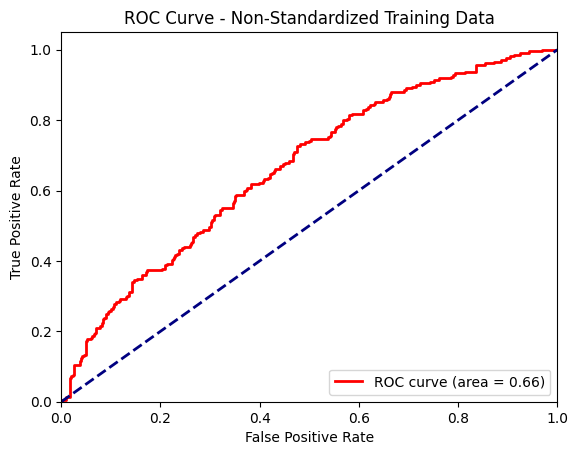

In [23]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Non-Standardized Training Data')
plt.legend(loc="lower right")
plt.show()

**Calculation Sensivity and Specificity**

Our model sensitivity is **lower** and specificity **higher** than the original project's results.

In [24]:
# True labels and predicted labels are available as lists or arrays
true_labels = y_test
predicted_labels = lrn.predict(sm.add_constant(X_test))

# Define cut-point values
thresholds = [0.25, 0.5, 0.6]
results=[]

for threshold in thresholds:
    # Convert predicted labels based on the current threshold
    predicted_labels_threshold = np.where(predicted_labels >= threshold, 1, 0)
    
    # Calculating confusion matrix for the current threshold
    conf_matrix = confusion_matrix(true_labels, predicted_labels_threshold)
    
    # Extracting values from the confusion matrix
    TN, FP, FN, TP = conf_matrix.ravel()
    
    # Calculate sensitivity (true positive rate)
    sensitivity = TP / (TP + FN)
    
    # Calculate specificity (true negative rate)
    specificity = TN / (TN + FP)
    
    # Print the results
    results.append({'Cut-point': threshold,
                    'Sensitivity': sensitivity,
                    'Specificity': specificity})
#Show the results    
pd.DataFrame(results)

,Cut-point,Sensitivity,Specificity
0,0.25,0.659341,0.478469
1,0.50,0.109890,0.976077
2,0.60,0.065934,0.995215


**Calculation of correct clasifications for the cut-points**

In comparison to the original research, our results in 0.25 cut-point **increase**, but for 0.5 and 0.6 cut-point **decrease**.

In [25]:
# Initialize an empty list to store the results
results2 = []

# Define cut_point values
cut_points = [0.25, 0.5, 0.6]

# Loop through each threshold value
for cut_point in cut_points:
    # Convert predicted labels based on the current cut-point
    predicted_labels_threshold = np.where(predicted_labels >= cut_point, 1, 0)
    
    # Calculate the proportion of correct classifications for the current cut_point
    correct_classification = (predicted_labels_threshold == y_test).mean()
    
    # Append the results to the list
    results2.append({'Cut-point': cut_point,
                     'Proportion of Correct Classifications': correct_classification})

# Display the results
pd.DataFrame(results2)


,Cut-point,Proportion of Correct Classifications
0,0.25,0.533333
1,0.50,0.713333
2,0.60,0.713333


**Fit the models on the train set standardized data**

In [26]:
# Create scaler for standardization of data
scaler = StandardScaler()
# Transform the data 
X_transform=pd.DataFrame(scaler.fit_transform(X),columns=['duration','amount','installment','residence','age','cards','liable'])
# Create the new train and test data for transform data
X_train_transform,X_test_transform,y_train,y_test=train_test_split(X_transform,y,train_size=0.70,random_state=42)
# Fit the logistic regression model
lrn_s = sm.Logit(y_train, sm.add_constant(X_train_transform)).fit()
# Print the summary of the logistic regression model
lrn_s.summary()

Optimization terminated successfully.
         Current function value: 0.574276
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                  700
Model:                          Logit   Df Residuals:                      692
Method:                           MLE   Df Model:                            7
Date:                Sun, 12 May 2024   Pseudo R-squ.:                 0.05802
Time:                        00:15:01   Log-Likelihood:                -401.99
converged:                       True   LL-Null:                       -426.75
Covariance Type:            nonrobust   LLR p-value:                 1.793e-08
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.9409      0.089    -10.606      0.000      -1.115      -0.767
duration        0.2529      0.112      2.253      0.024       0.033       0.473
amount          0.2499      0.109      2.284      0.022       0.035       0.464
installment     0.2124      0.096      2.205      0.027       0.024       0.401
residence       0.0869      0.089      0.971      0.331      -0.088       0.262
age            -0.3971      0.103     -3.858      0.000      -0.599      -0.195
cards          -0.0925      0.091     -1.021      0.307      -0.270       0.085
liable          0.0762      0.092      0.829      0.407      -0.104       0.256
===============================================================================
"""

In [27]:
# Calculation AIC
lrn_s.aic

819.987038400438

**Calculation top 10 predictions and their probabilities**

In [28]:
# Predicted probabilities in the training data
y_pred_prob = lrn_s.predict(sm.add_constant(X_train_transform))

# Create DataFrame with predicted probabilities and actual 'Default' values
y_pred_df = pd.DataFrame({'pred': y_pred_prob, 'Default': y})

# Select top 10 observations with highest predicted probabilities
top_10_pred_y = y_pred_df.nlargest(10, 'pred')

# Classify predictions based on a threshold of 0.5
y_pred_df['pred.c'] = np.where(y_pred_df['pred'] >= 0.5, 'Yes', 'No')

# Display top 10 predictions and their probabilities
top_10_pred_y

,pred,Default
637,0.779487,0
887,0.720171,1
134,0.718063,0
744,0.680709,0
685,0.679378,0
272,0.672265,0
915,0.664818,1
812,0.622604,1
921,0.622120,0
616,0.617833,0


**Calculate evaluation metrics non-standardized data**

Roc curve shape is almost the same as the original project's curve. 

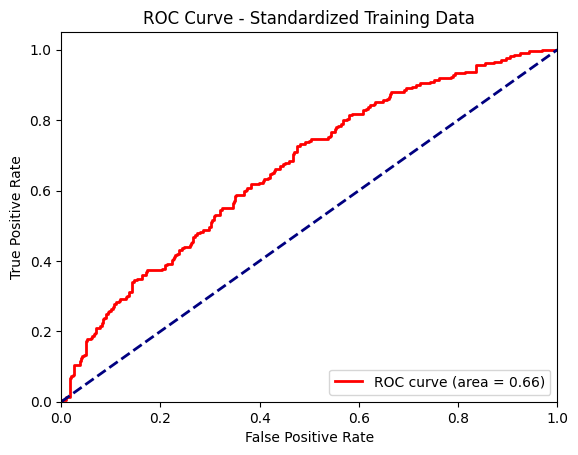

In [29]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Standardized Training Data')
plt.legend(loc="lower right")
plt.show()


**Calculation Sensivity and Specificity**

Our model sensitivity is **lower** and specificity **higher** than the original project's results.

In [30]:
# True labels and predicted labels are available as lists 
true_labels = y_test
predicted_labels = lrn_s.predict(sm.add_constant(X_test_transform))

# Define cut-point values
thresholds = [0.25, 0.5, 0.6]
results=[]

for threshold in thresholds:
    # Convert predicted labels based on the current threshold
    predicted_labels_threshold = np.where(predicted_labels >= threshold, 1, 0)
    
    # Calculating confusion matrix for the current threshold
    conf_matrix = confusion_matrix(true_labels, predicted_labels_threshold)
    
    # Extracting values from the confusion matrix
    TN, FP, FN, TP = conf_matrix.ravel()
    
    # Calculate sensitivity (true positive rate)
    sensitivity = TP / (TP + FN)
    
    # Calculate specificity (true negative rate)
    specificity = TN / (TN + FP)
    
    # Print the results
    results.append({'Cut-point': threshold,
                    'Sensitivity': sensitivity,
                    'Specificity': specificity})
# Show the results    
pd.DataFrame(results)

,Cut-point,Sensitivity,Specificity
0,0.25,0.659341,0.478469
1,0.50,0.109890,0.976077
2,0.60,0.065934,0.995215


**Calculation of Correct clasifications for the cut-points**

In comparison to the original research, our results in 0.25 cut-point **increase**, but for 0.5 and 0.6 cut-points  **decrease**.

In [31]:
# Initialize an empty list to store the results
results2 = []

# Define cut_point values
Cut_points = [0.25, 0.5, 0.6]

# Loop through each threshold value
for Cut_point in Cut_points:
    # Convert predicted labels based on the current cut_point
    predicted_labels_threshold = np.where(predicted_labels >= Cut_point, 1, 0)
    
    # Calculate the proportion of correct classifications for the current cut_point
    correct_classification = (predicted_labels_threshold == y_test).mean()
    
    # Append the results to the list
    results2.append({'Cut-point': Cut_point,
                     'Proportion of Correct Classifications': correct_classification})

# Display the results
pd.DataFrame(results2)

,Cut-point,Proportion of Correct Classifications
0,0.25,0.533333
1,0.50,0.713333
2,0.60,0.713333


**Results**

1. Our models' AIC results are lower than the original project's results. It means, our model is more powerful. But our model $R^{2}$ score is too low, unfortunately in the original project, the author did not calculate $R^{2}$ and we cannot compare the $R^{2}$ score of the two models.
2. The author used standardized and non-standardized data for modeling purposes, but standardization does not significantly affect the result in either our or the original model.